In [73]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
import sklearn
from sklearn_pandas import DataFrameMapper
from skopt import BayesSearchCV
from tqdm import tqdm_notebook as tqdm

# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 1000

%matplotlib inline

In [2]:
# define some functions

class tqdm_skopt(object):
    """Utility class for creating progress bar for skopt"""
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
        
    def __call__(self, res):
        self._bar.update()

def regex_select(lst, regex):
    """
    Return all values from a list of strings that match any of the supplied regexes.
    """
    if isinstance(regex, str):
        regex = [regex]
        
    results = []
    for value in lst:
        for pattern in regex:
            if re.search(pattern, value):
                results.append(value)
                break
    return results

def invert_dict(d):
    """
    Invert a dictionary to return mapping from values to keys. 
    
    Errors if values are not unique.
    """
    result = {}
    for key, value in d.items():
        if value in result:
            raise ValueError(f"Duplicate key: {value}")
        result[value] = key
    return result

def effective_sample_sizes(y,p):
    """Compute effective sample size for treated, control and overall."""
    w = 1/p
    treated = effective_sample_size(w[y==1])
    control = effective_sample_size(w[y==0])
    overall = effective_sample_size(w)
    return treated, control, overall

def effective_sample_size(w):
    """Measure of distribution overlap see https://arxiv.org/pdf/2010.09563.pdf."""
    return int(np.floor(np.sum(w)**2/np.sum(w**2)))

def visualise_propensity_model_performance(y,p, model_name, bins=30):
    """Visualise the distribution of scores in each class and the ROC curve."""
    
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, p)
    area = sklearn.metrics.roc_auc_score(y,p)
    n_treated, n_control = (y == 1).sum(), (y == 0).sum()
    n_treated_eff, n_control_eff, _ = effective_sample_sizes(y,p)
    

    fig,ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title(f"Propensity score overlap ({model_name})")
    ax[0].hist(p[y==0],label=f'y=0, n={n_control}({n_control_eff})', alpha=0.5,bins=bins)
    ax[0].hist(p[y==1],label=f'y=1, n={n_treated}({n_treated_eff})', alpha=0.5,bins=bins)
    ax[0].legend(loc="upper right")
    ax[0].set_xlabel("propensity")
    ax[0].set_ylabel("frequency")
    ax[0].set_xlim(0,1)
    
    ax[1].plot(fpr,tpr, label=f'ROC-curve (area = {area:.2f})')
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title(f"ROC-curve ({model_name})")
    ax[1].legend(loc="lower right")
    

# Load the data

### Treatent variables


   - **redhllt**
   - **redllt** 
   - **refllt** 
   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Mental health in 2019 (**mh**). This is the transformed mental health scores from the aggregation of mental health items of the SF-36 Health Survey, as reported by the individual in 2019. It ranges from 0 to 100, with higher scores indicating better mental health.  
   - Working hours in 2019 (**wkhr**) records the total number of hours the individual works in all jobs in a week on average. Working hours are set to 0 for those not working. 
   - Hourly Wages in 2019 (**rlwage**) records the average hourly wage for the individual’s main job in 2019. Hourly wages are set to 0 for those not working and set to missing for those reporting working more than 100 hours a week. 

In [3]:
treatments = ['reduhl', 'rehllt', 'redudl', 'redufl', 'redllt', 'refllt']
outcomes = ['rlwage', 'mh', 'mhbm', 'wkhr']

def load_data(fmt,treatments,outcomes):   
    fmts=['basic','raw','anna']
    assert fmt in fmts,f"format must be in {fmts}"
    df, meta = pyreadstat.read_dta("../reduregvars.dta")
    df['xwaveid'] = df['xwaveid'].astype(int)
    
    if fmt in ['basic','raw']:
        # merge the variables extract in python from the outcome and treatment variables Anna encoded
        # also preserves row selection
        treat_outcome = df[treatments+outcomes+['xwaveid']].copy()
        if fmt == 'basic':
            variables = pd.read_csv('basic_variables.csv')
        else:
            variables = pd.read_csv('all_vars.csv')
        df = pd.merge(treat_outcome,variables,how='left',on=['xwaveid'])
        
    
    else:
        # un-bin age
        age_vars = ['p_age1', 'p_age2', 'p_age3', 'p_age4', 'p_age5', 'p_age1miss']
        age = pd.read_csv('all_vars.csv',usecols=['xwaveid','ahgage'])
        df.drop(columns=age_vars,inplace=True)
        df = pd.merge(df,age,how='left',on=['xwaveid'])

    
    return df, meta 

## Propensity Model

What features are predictive of someone undertaking re-education?

### Specify target and features
For this model, we are predicting whether or not an individual is treated (eg is re-educated) so the target will be one of the measures of re-education.

#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment)
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)

In [4]:

def select_features(df):
    exclude = regex_select(df.columns,
    [
        '^p_rcom',
        '^p_rdf',
        '^p_cotrl',
        '^xwaveid$',
        'p_rcom18'#?
        '^aedcq', # indicate studying at start - these people should already have been removed
        '^abnfsty',
        '^aedcqfpt',
        '^aedqstdy' 
    ])
    
    # We need to filter out columns that are entirely missing,
    # otherwise they are dropped by SimpleImputer, and we can't track which ones.
    entirely_missing = set({})
    for col in df.columns:
        if df[col].isnull().all():
            entirely_missing.add(col)
    
    if len(entirely_missing) > 0:
        print(f"Dropping {len(entirely_missing)} entirely null columns:{entirely_missing}")

    features = list(set(df.columns)-set(exclude) - set(treatments) - set(outcomes) - set(entirely_missing))

    print(f'Original columns:{len(df.columns)}, excluded:{len(df.columns) - len(features)}, # features:{len(features)}')
    print(f'Re-education rate:{df[treatment].mean():.2f}')
    
    return features


### Set up models

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from dataclasses import dataclass, field
from typing import Any, Dict
from interpret.glassbox import ExplainableBoostingClassifier

# select splits in advance so the same ones are used for all models.
np.random.seed(666)
indx = np.arange(5298)
train_indx, test_indx = train_test_split(indx)


@dataclass
class Model:
    """Class keeping a model, its human readable name and the set of parameters to search over for it together."""
    name:str
    estimator:Any
    parameters:Dict = field(default_factory=dict)
        
def prepare_data(df, features, target, train_indx, test_indx):
    """Seperate training and test data, filter out rows missing target, impute & scale."""    
    transform = Pipeline([
        ('impute_missing', SimpleImputer()),
        ('scale', StandardScaler())
    ])

    X = transform.fit_transform(df[features])
    y = df[treatment]
    assert np.ndim(y)==1
    assert X.shape[1] == len(features),"Number of columns in X should match number of features"

    X_train, X_test, y_train, y_test = X[train_indx,:],X[test_indx,:],y[train_indx],y[test_indx]

    def drop_obs_missing_y(X,y):
        valid = ~np.isnan(y)
        Xnew = X[valid,:]
        ynew = y[valid]
        return Xnew,ynew
        
    X_train, y_train = drop_obs_missing_y(X_train,y_train)
    X_test, y_test = drop_obs_missing_y(X_test,y_test)

    return X_train, X_test, y_train, y_test


def construct_models():
    models = [
        Model('lr',LogisticRegression(penalty='none',solver='saga',max_iter=1000)),
        Model('explain-boost',ExplainableBoostingClassifier()),
        Model('lr-ridge',LogisticRegression(),
              parameters = {
                  'C':np.logspace(-5,0,20)
              }
        ), 
        Model('gbc',GradientBoostingClassifier(n_iter_no_change=20, max_depth=2),
              parameters = {
                'max_features':[10,20,40,60,80],
                'learning_rate':np.logspace(-6,-1,10),
                'min_samples_leaf':np.logspace(0,3,10).astype(int)
              }
        ),

    ]
    return models

### Fit models and visualise performance

In [6]:
from sklearn.inspection import permutation_importance
def fit_models(models, optimisation_metric, X_train, y_train):
    """Fit a list of models optimising hyper-parameters on the specified metric."""
    print("Training data shape:",X_train.shape)
    for model in models:
        inner_cv = KFold(n_splits=5)
        if len(model.parameters) > 0:
            search = GridSearchCV(
                estimator=model.estimator, param_grid=model.parameters, verbose=2,
                n_jobs=-1, scoring = optimisation_metric, cv = inner_cv, refit=True
            )
            search.fit(X_train,y_train)
            model.fit_estimator = search
        else:
            model.estimator.fit(X_train,y_train)
            model.fit_estimator = model.estimator
            
def visualise_performance(models, X_test, y_test):
    for model in models:
        p = model.fit_estimator.predict_proba(X_test)[:,1]
        visualise_propensity_model_performance(y_test,p, model.name) 

def extract_importance(models,X_test, y_test, features):
    importances = {}
    for model in models:
        importances[f"permutation-{model.name}"] = permutation_importance(
            model.fit_estimator, X_test, y_test, n_repeats=30, n_jobs=-1, scoring=optimisation_metric
        ).importances_mean

        if hasattr(model.fit_estimator,'best_estimator_'):
            base = model.fit_estimator.best_estimator_
        else:
            base = model.fit_estimator

        if hasattr(base,'coef_'):
            importances[f'coef-{model.name}'] = base.coef_[0]

    importances = pd.DataFrame(importances,index=features)
    return importances

def visualise_importance_distribution(importances):
    """Visualise the distribution of feature importances."""
    prefix = "permutation-"
    permutation = regex_select(importances.columns, [f'^{prefix}'])
    
    
    def get_plot_element(ax,i):
        if hasattr(ax, "__getitem__"):
            return ax[i]
        return ax
        
    l = len(permutation)
    fig,ax = plt.subplots(1,l,figsize=(l*5,5))
    for i,column in enumerate(permutation):
        model_name = column[len(prefix):]
        e = get_plot_element(ax,i)
        e.hist(importances[column],bins=30,label=model_name)
        e.legend(loc='upper right')
        e.set_xlabel('permutation importance')
        e.set_ylabel('count')
        e.set_title('Distribution of feature importance')
        

optimisation_metric = 'roc_auc'        

#### Raw feature set

This feature set contains every variable observed in 2001, with very little filtering or pre-processing. The minimal preprocessing includes;
   - removing variables that are more than 95% missing
   - merging variables that are almost perfectly correlated (> .95) 
   - removing variables with 0 variance
   - changing dates to days past an epoch

Dropping 32 entirely null columns:{'acaept17', 'aedcqc4', 'acaept20', 'acaept34', 'acaept37', 'acaept39', 'acaept42', 'acaept27', 'acaeft22', 'aedcqnt', 'acaept31', 'acaept24', 'aedcqbc', 'acaept01', 'aedcqc3', 'aedcqdn', 'aedcqta', 'aedcqnei', 'aedcqtq', 'acaeft24', 'acaeft38', 'aedcqcc', 'acaept22', 'acaept38', 'acaeft41', 'aedcqos', 'aedcqtc', 'acaeft29', 'aedcqna', 'aedcqcn', 'acaept14', 'aedcqnq'}
Original columns:1120, excluded:46, # features:1074
Re-education rate:0.24
Training data shape: (3969, 1074)


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.0s finished


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 1445 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1890 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2417 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  2.8min finished


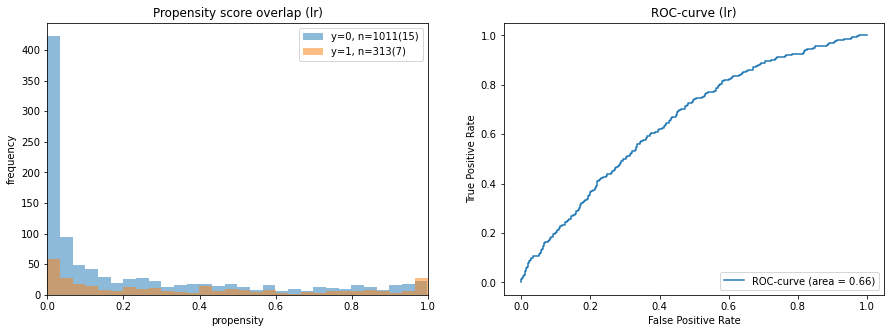

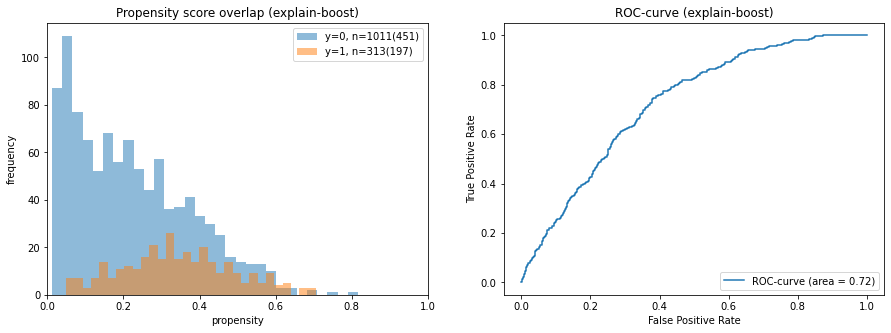

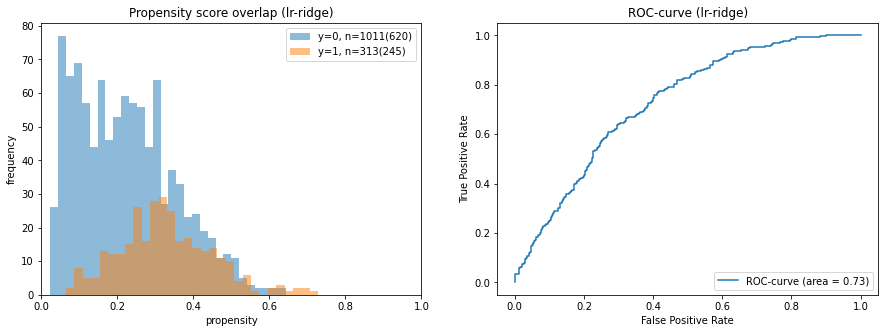

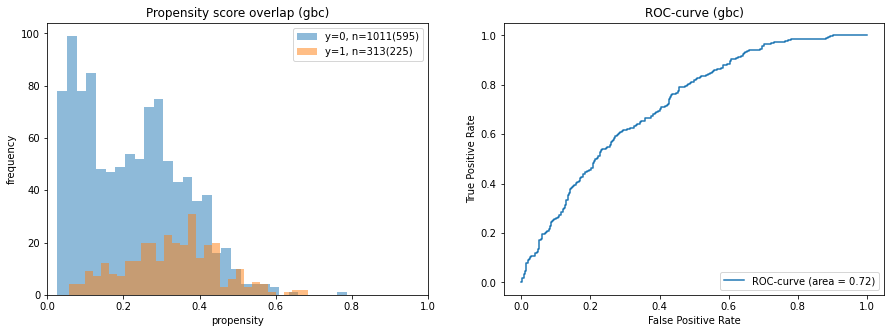

In [7]:
models_raw = construct_models()
treatment = 'redudl' #reduhl, #refllt
df,meta = load_data('raw',treatments,outcomes)
features_r = select_features(df)
Xr_train, Xr_test, yr_train, yr_test = prepare_data(df, features_r, treatment,train_indx,test_indx)
fit_models(models_raw,optimisation_metric,Xr_train,yr_train)
visualise_performance(models_raw,Xr_test,yr_test)

In [ ]:
importances_r = extract_importance(models_raw,Xr_test,yr_test,features_r)

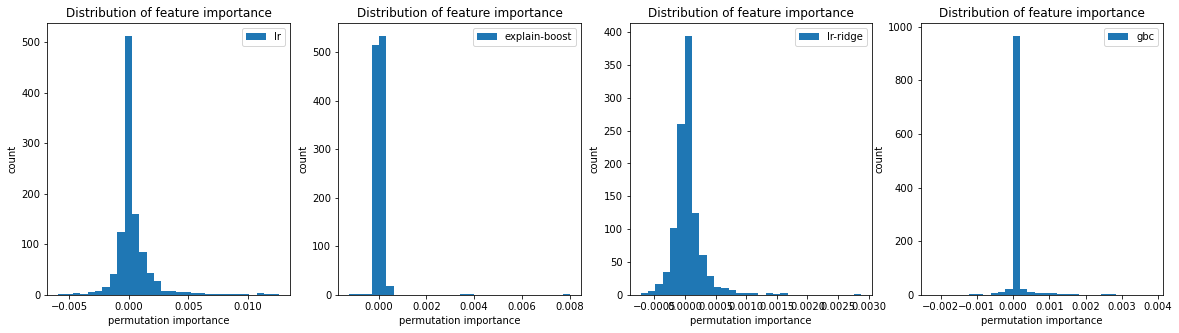

In [48]:
visualise_importance_distribution(importances_r)

In [70]:
# get column labels
s='a'
_, meta1 = pyreadstat.read_sav(f'../part1/Combined {s}190c.sav') 
del(_)

In [74]:
column_labels = meta1.column_names_to_labels
importances_r['label'] = [ column_labels.get(name,"") for name in importances_r.index]
importances_r.sort_values('permutation-lr-ridge',ascending=False).head(20)

,permutation-lr,coef-lr,permutation-explain-boost,permutation-lr-ridge,coef-lr-ridge,permutation-gbc,label
ajbnewjs,0.003916,-0.123877,0.000565,0.002876,-0.024346,0.002729,"E37 At any time in the last 4 weeks, have you actually looked for a new job"
aedq524,0.001520,0.160573,0.000245,0.001612,0.026674,0.000243,DV: ASCED 524 Certificate level I - Number of qualifications obtained since leaving school
accdifrp,0.001069,0.094909,0.000120,0.001566,0.016801,0.001661,Q4b Difficulty in last 12 months - finding the right person to take care of my child
aedqenr,0.006313,-0.236209,0.000123,0.001543,-0.031227,0.000000,C6 Ever enrolled in a course of study to obtain a qualification
artage2,0.010778,-0.337569,0.000151,0.001404,-0.039365,0.002473,F21 Check age 45 or older
afibcar,0.002256,-0.122634,0.000260,0.001346,-0.020920,0.000000,SCQ:C7d Alright to borrow for - Car
ahgage,0.011299,-0.269709,0.000566,0.001335,-0.038648,0.003842,DV: Age last birthday at June 30 2001
ajbocct,0.004109,-0.269718,0.008021,0.001192,-0.039987,0.001089,DV: Tenure in current occupation (years)
afibeduc,0.001805,-0.113102,0.000341,0.001185,-0.024427,0.000000,SCQ:C7e Alright to borrow for - Education
aiohelp,0.001710,0.154232,0.000297,0.001096,0.018016,0.000000,Z8a Assistance of 3rd party


#### Large feature set

This is a set of features selected by Anna as the broad set that may be relevant. Some variables have been one-hot encoded. 

Original columns:185, excluded:40, # features:145
Re-education rate:0.24
Training data shape: (3969, 145)


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  77 out of 100 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1092 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 1457 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 1902 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2429 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  1.5min finished


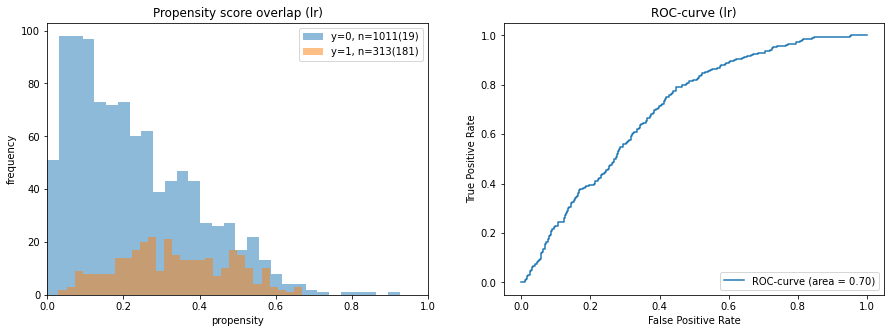

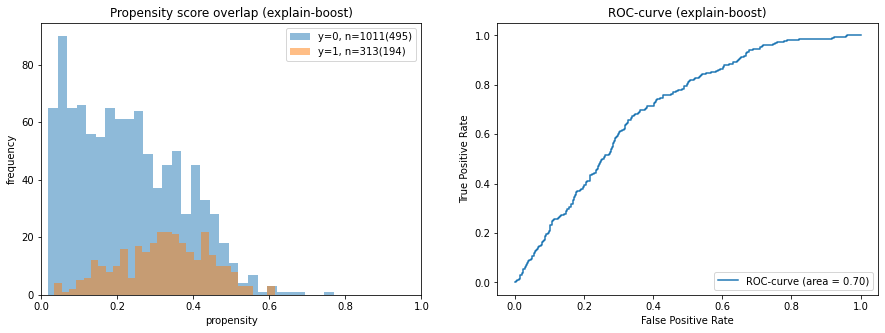

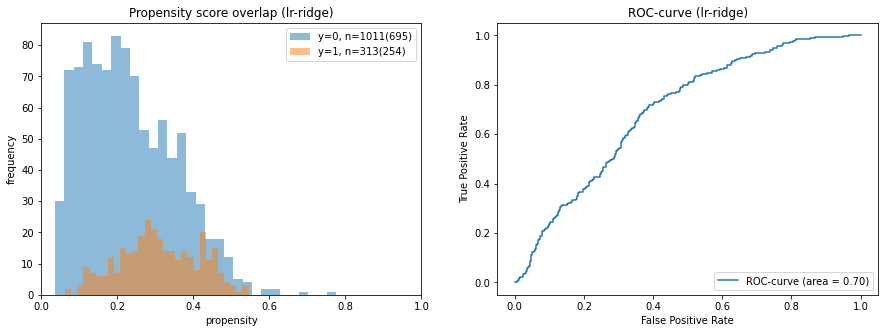

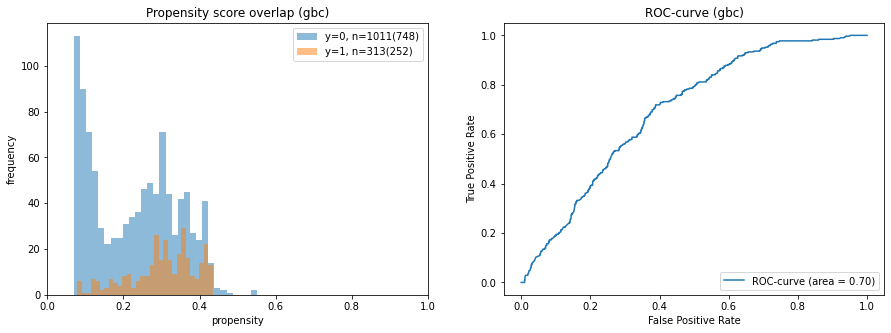

In [61]:
models_large = construct_models()
treatment = 'redudl' #reduhl, #refllt
df,meta_l = load_data('anna',treatments,outcomes)
features_l = select_features(df)
Xl_train, Xl_test, yl_train, yl_test = prepare_data(df, features_l, treatment,train_indx,test_indx)
fit_models(models_large,optimisation_metric,Xl_train,yl_train)
visualise_performance(models_large,Xl_test,yl_test)

In [ ]:
importances_l = extract_importance(models_large,Xl_test,yl_test,features_l)

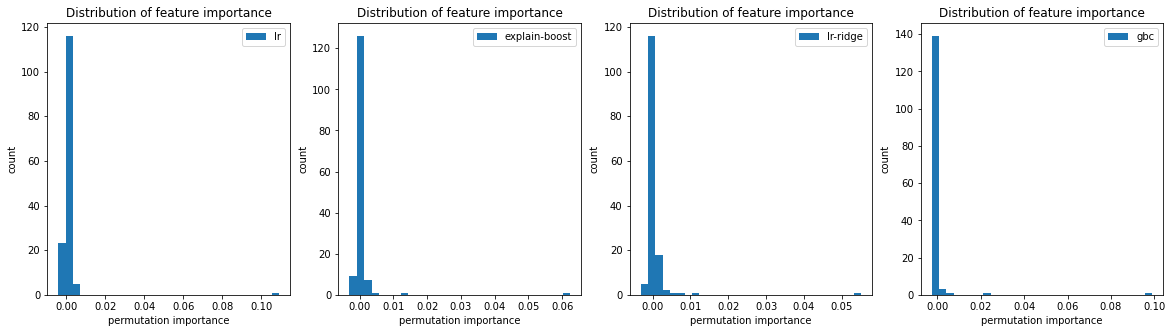

In [49]:
visualise_importance_distribution(importances_l)

##### Features ranked by permutation importance

In [68]:
column_labels = meta_l.column_names_to_labels
importances_l['label'] = [ column_labels.get(name,"") for name in importances_l.index]
importances_l.sort_values('permutation-lr-ridge',ascending=False).head(20)

,permutation-lr,coef-lr,permutation-explain-boost,permutation-lr-ridge,coef-lr-ridge,permutation-gbc,label
ahgage,0.109128,-0.644462,0.062318,0.055097,-0.299109,0.098997,
p_wh01,0.003509,0.076048,0.012869,0.010683,0.123141,0.021825,Total weekly working hours in 2001
p_noch,0.006199,0.166182,0.004300,0.008377,0.135048,-0.000230,Number of dependent children in 2001
p_mar3,0.004300,0.092781,0.002684,0.004684,0.064596,0.001501,Marital status in 2001: Separated
p_lfs2,0.005502,0.171661,0.001907,0.004568,0.111697,0.000682,Labour market status in 2001: Unemployed
p_fem,0.003649,0.181515,0.002068,0.003800,0.110942,0.005790,Female
p_whp2,0.001861,0.027263,0.002664,0.002561,0.027889,0.000000,Extent of hours match with preference in 2001:...
p_jadnm,0.006493,0.125821,0.002606,0.002315,0.048578,0.001199,SCQ:D1b I would enjoy having a job even if I d...
p_losat,0.003159,-0.101605,0.000712,0.001941,-0.057102,0.000523,Life satisfaction in 2001
p_con2,0.002750,0.057805,0.001774,0.001686,0.042567,0.000238,Contract type in 2001: Fixed term


#### Minimal feature set
This is the very minimal set of features used in the original paper. It consists of 4 variables, (sex, age, education, employment). Each is one-hot encoded and interactions are added between sex and the other variables.

Original columns:32, excluded:11, # features:21
Re-education rate:0.24
Training data shape: (3969, 21)


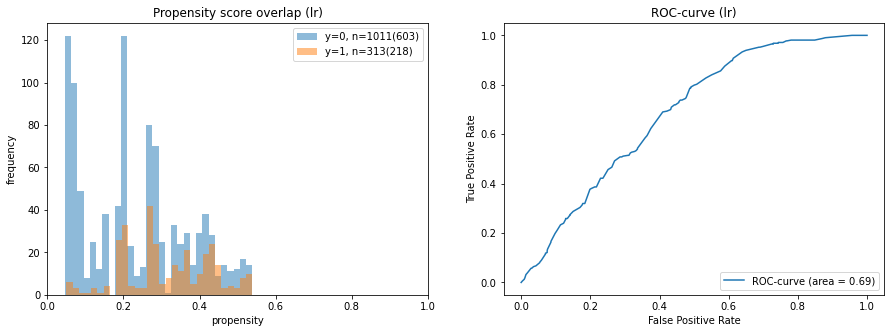

In [9]:
models_basic = [construct_models()[0]]
treatment = 'redudl' #reduhl, #refllt
df,meta = load_data('basic',treatments,outcomes)
features_b = select_features(df) 
Xb_train, Xb_test, yb_train, yb_test = prepare_data(df, features_b, treatment,train_indx,test_indx)
fit_models(models_basic,optimisation_metric,Xb_train,yb_train)
visualise_performance(models_basic,Xb_test,yb_test)

In [44]:
importances_b = extract_importance(models_basic,Xb_test,yb_test,features_b)

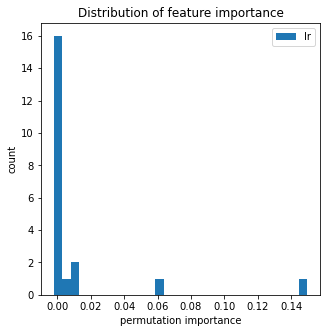

In [50]:
visualise_importance_distribution(importances_b)

In [54]:
importances_b.sort_values('permutation-lr',ascending=False).head(10)

,permutation-lr,coef-lr
"ahgage_(54, 120]",0.149621,-0.875855
"ahgage_(44, 54]",0.061341,-0.415377
aedhigh1_9.0,0.011874,-0.255872
ahgsex_2.0,0.009717,0.223535
"ahgage_(34, 44]",0.006281,-0.198938
interact_ahgsex_2.0_aesdtl_NotEmpl,0.002692,-0.132044
aedhigh1_8.0,0.002608,-0.032205
"interact_ahgsex_2.0_ahgage_(44, 54]",0.002076,-0.026300
interact_ahgsex_2.0_aedhigh1_9.0,0.002006,0.072849
aesdtl_NotEmpl,0.001281,0.025076
